In [ ]:
from evostra.algorithms import ESCompetitiveMutationAverage
from evostra.algorithms import ESCompetitiveMutationBest, ESCompetitiveMutationCrossover

In [ ]:
observations = 9
possible_moves = 9

layer_sizes = [observations, 15, possible_moves]

In [ ]:
class Agent:
    def __init__(self):
        pass
    
    def predict(self, board):
        raise NotImplementedError
    
class AgentModel(Agent):
    def __init__(self, model):
        self.model = model
    
    def predict(self, board):
        prediction = self.model.predict(board.flatten())
        return prediction
    
class AgentHuman(Agent):
    def __init__(self):
        pass
    
    def predict(self, board):
        move = int(input("Select move: "))
        prediction = [1 if i == move else 0 for i in range(9)]
        return prediction
    
class AgentRandom(Agent):
    def __init__(self):
        pass
    
    def predict(self, board):
        prediction = np.random.randn(9)
        return prediction

In [ ]:
def get_reward(*env):
    global layer_sizes
    w1, prev_bests = env[0], env[1]
    m1 = FeedForwardNetwork(layer_sizes=layer_sizes)
    m1.set_weights(w1)
    reward = 0
    m2 = FeedForwardNetwork(layer_sizes=layer_sizes)
    for prev_best in prev_bests:
        game = Tris()
        m2.set_weights(prev_best)
        reward += game.play_game(AgentModel(m1), AgentModel(m2))
    return reward

In [ ]:
PLAYER_1 = 1
PLAYER_2 = -1
DRAW = 0
EMPTY = 0
CONTINUE = 2
players = {"player_1": PLAYER_1, "player_2": PLAYER_2}

class Tris(object):
    def __init__(self):
        self.board = np.array([np.array([EMPTY for i in range(3)]) for j in range(3)])
        
    def check_win(self):
        # check rows
        board = self.board
        for row in board:
            for _,player in players.items():
                if np.all(np.equal(row, np.full(3, player))):
                    return player
        
        # check cols
        board = self.board.transpose()
        for row in board:
            for _,player in players.items():
                if np.all(np.equal(row, np.full(3, player))):
                    return player
                
        # check diagonals
        diags = []
        diags.append(np.array([board[i][i] for i in range(3)]))
        diags.append(np.array([board[i][3 - i - 1] for i in range(3)]))
        for row in diags:
            for _,player in players.items():
                if np.all(np.equal(row, np.full(3, player))):
                    return player
        
        # check draw
        exist_empty = False
        for row in self.board:
            for cell in row:
                if cell == EMPTY:
                    exist_empty = True
        if not exist_empty:
            return DRAW
        
        return CONTINUE
    
    def extract_move(self, prediction):
        highest_value = -10
        highest_value_index = -1
        for i,pred in enumerate(prediction):
            if self.board[i//3][i%3] == EMPTY and pred > highest_value:
                highest_value = pred
                highest_value_index = i
        return highest_value_index
    
    def do_move(self, move, player):
        self.board[move//3][move%3] = player
        
    def opposite_board(self):
        return np.array([np.array([PLAYER_2 if self.board[row][col] == PLAYER_1
                                   else PLAYER_1 if self.board[row][col] == PLAYER_2
                                   else EMPTY for col in range(3)]) for row in range(3)])
    
    def play_game(self, agent_1, agent_2, interactive=False):
        player_turn = np.random.choice([PLAYER_1, PLAYER_2])
        
        if interactive:
                self.print_board() 
        
        result = self.check_win()
        while result == CONTINUE:
            if player_turn == PLAYER_1:
                prediction = agent_1.predict(self.board)
            else:
                prediction = agent_2.predict(self.opposite_board())
              
            move = self.extract_move(prediction)
            self.do_move(move, player_turn)
            
            if interactive:
                self.print_board()
            
            if player_turn == PLAYER_1:
                player_turn = PLAYER_2
            else:
                player_turn = PLAYER_1
                
            result = self.check_win()
            
        if interactive:
                self.print_board()    
        
        return result
    
    def print_board(self):
        for row in self.board:
            for cell in row:
                print(cell, end=" ")
            print("")
        print("-"*30)

In [ ]:
model = FeedForwardNetwork(layer_sizes=layer_sizes)
es = ESCompetitiveMutationBest(get_reward, weights=model.get_weights(), n_best=30,
                       population_size=80, sigma=0.05, learning_rate=0.03, decay=0.995, num_threads=-1)

In [ ]:
es.run(iterations=300, print_step=1)

In [ ]:
model = FeedForwardNetwork(layer_sizes=layer_sizes)
es = ESCompetitiveMutationCrossover(get_reward, weights=model.get_weights(), n_best=30,
                       population_size=80, sigma=0.05, num_threads=-1, percs=[0.7,0.2,0.1])

In [ ]:
es.run(iterations=300, print_step=1)

In [ ]:
game = Tris()
optimized_weights = es.get_weights()
model.set_weights(optimized_weights)
game.play_game(AgentHuman(), AgentModel(model), interactive=True)

# Prova da libreria

In [1]:
from evoframe import get_agent_wrapper_func
from evoframe.reward_builders import RewardBuilderGame
from evoframe.population_update_builders import PopulationUpdateBuilderStatic
from evoframe.selector_function import SelectorFunctionFactory
from evoframe import PopulationManager
from evoframe.models import FeedForwardNetwork
from evoframe.models import ActivationFunctions
from evoframe.games import GuessPoint
from evoframe.games import Game

from itertools import product
import numpy as np

# Guess the point

In [46]:
# Game
game_creation_function = lambda: GuessPoint(np.array([0.2,0.8,0.5]), np.array([0.4, 0.5, 10]))

# Model
layer_sizes = [3, 5, 3]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_arctan(), ActivationFunctions.get_id())

# Game-Model interface
predict_func = lambda model, inputs: model.predict(inputs)
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.get()

# Update population function
mutation_perc = 0.6
crossover_perc = 0.3
copy_perc = 0.1
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", mutation_perc, 0.3, 0.3) \
.add_operator("es_2_crossover", crossover_perc, 0.8) \
.add_operator("es_1_copy", copy_perc) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 500
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 10
last_pop = pm.run(num_epochs)

-3.089572212614923
-12.88356435674956
-12.88356435674956
-12.88356435674956
-12.88356435674956
-12.88356435674956
-12.88356435674956
-12.88356435674956
-12.88356435674956
-12.88356435674956


# Guess the function

In [ ]:
class GuessFunction(Game):
    """This game consists in learning a function from n dimensions to m dimensions, evaluating points
        on a grid.

        1 player game.

        Agent interface:
        - input: n-dimensional np.array filled with values
        - output: m-dimensional np.array filled with values
        """
    def __init__(self, func, input_dim, input_domains, sample_every):
        self.func = func
        self.input_dim = input_dim # input dimension
        self.input_domains = input_domains # domain for each scalar in the input vector
        self.sample_every = sample_every # sampling bin for each scalar in the input vector

    def play(self, agent):
        error = 0
        ranges = []
        for i in range(self.input_dim):
            input_domain = self.input_domains[i]
            sample_every = self.sample_every[i]
            ranges.append(np.arange(input_domain[0], input_domain[1], sample_every))
        for input_tuple in product(*ranges):
            input_array = np.array(input_tuple)
            predictions = agent.predict(input_array)
            error += np.sum(np.square(self.func(input_array) - predictions))
        reward = -error
        return reward

In [ ]:
# Game
game_func = lambda i: np.array([2*i[0]-3*i[1]+4, i[1]-8*i[2]-5])
input_dim = 3
input_domains = [(-1,1),(-1,1),(3,7)]
sample_every = [0.1, 0.1, 0.3]
game_creation_function = lambda: GuessFunction(game_func, input_dim, input_domains, sample_every)

# Model
layer_sizes = [3, 5, 2]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_arctan(), ActivationFunctions.get_id())

# Game-Model interface
predict_func = lambda model, inputs: model.predict(inputs)
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.get()

# Update population function
mutation_perc = 0.6
crossover_perc = 0.3
copy_perc = 0.1
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", mutation_perc, 0.3, 0.5) \
.add_operator("es_2_crossover", crossover_perc, 0.1) \
.add_operator("es_1_copy", copy_perc) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 30
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 100
last_pop = pm.run(num_epochs)

In [ ]:
test_array = np.array([0.5,0.5,5])
last_pop[0].predict(test_array), game_func(test_array)

# Play Tris

In [17]:
PLAYER_1 = 1
PLAYER_2 = -1
DRAW = 0
EMPTY = 0
CONTINUE = 2
players = {"player_1": PLAYER_1, "player_2": PLAYER_2}

class Tris(Game):
    def __init__(self):
        self.board = np.array([np.array([EMPTY for i in range(3)]) for j in range(3)])
        
    def check_win(self):
        # check rows
        board = self.board
        for row in board:
            for _,player in players.items():
                if np.all(np.equal(row, np.full(3, player))):
                    return player
        
        # check cols
        board = self.board.transpose()
        for row in board:
            for _,player in players.items():
                if np.all(np.equal(row, np.full(3, player))):
                    return player
                
        # check diagonals
        diags = []
        diags.append(np.array([board[i][i] for i in range(3)]))
        diags.append(np.array([board[i][3 - i - 1] for i in range(3)]))
        for row in diags:
            for _,player in players.items():
                if np.all(np.equal(row, np.full(3, player))):
                    return player
        
        # check draw
        exist_empty = False
        for row in self.board:
            for cell in row:
                if cell == EMPTY:
                    exist_empty = True
        if not exist_empty:
            return DRAW
        
        return CONTINUE
    
    def extract_move(self, prediction):
        highest_value = -10
        highest_value_index = -1
        for i,pred in enumerate(prediction):
            if self.board[i//3][i%3] == EMPTY and pred > highest_value:
                highest_value = pred
                highest_value_index = i
        return highest_value_index
    
    def do_move(self, move, player):
        self.board[move//3][move%3] = player
        
    def opposite_board(self):
        return np.array([np.array([PLAYER_2 if self.board[row][col] == PLAYER_1
                                   else PLAYER_1 if self.board[row][col] == PLAYER_2
                                   else EMPTY for col in range(3)]) for row in range(3)])
    
    def play(self, agent_1, agent_2, interactive=False):
        player_turn = np.random.choice([PLAYER_1, PLAYER_2])
        
        if interactive:
                self.print_board() 
        
        result = self.check_win()
        while result == CONTINUE:
            if player_turn == PLAYER_1:
                prediction = agent_1.predict(self.board)
            else:
                prediction = agent_2.predict(self.opposite_board())
              
            move = self.extract_move(prediction)
            self.do_move(move, player_turn)
            
            if interactive:
                self.print_board()
            
            if player_turn == PLAYER_1:
                player_turn = PLAYER_2
            else:
                player_turn = PLAYER_1
                
            result = self.check_win()
            
        if interactive:
                self.print_board()    
        
        return result
    
    def print_board(self):
        for row in self.board:
            for cell in row:
                print(cell, end=" ")
            print("")
        print("-"*30)

In [30]:
# Game
game_creation_function = lambda: Tris()

# Model
layer_sizes = [9, 5, 5, 9]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_arctan(), ActivationFunctions.get_id())

# Game-Model interface
def predict_func(model, inputs):
    # In Tris, 'inputs' is a 3x3 np.array, thus we must flatten it to a 9x1 np.array
    # output is a 9x1 vector, where the cell with highest value corresponding
    # to a valid move will be the chosen move
    return model.predict(inputs.flatten())[0]
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
# Since Tris is a two-players game, we can compute the reward with a tournament against the current generation
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.with_competitive_tournament() \
.get()

# Update population function
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_copy", 0.1) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 50
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 300
last_pop = pm.run(num_epochs)

19
18
12
16


KeyboardInterrupt: 

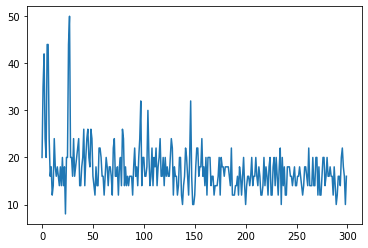

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

xs = np.arange(num_epochs)
ys_string = "20 35 42 24 20 44 44 24 16 18 12 14 24 18 16 18 16 14 18 14 20 14 18 8 20 20 44 50 20 20 16 24 16 18 20 22 24 14 14 18 20 26 14 20 24 26 20 18 26 24 16 14 12 18 14 14 22 22 20 16 16 12 16 20 18 14 18 18 16 12 22 24 16 16 18 12 18 20 14 26 24 14 18 14 16 14 16 16 16 12 18 22 16 18 14 20 24 32 14 20 20 16 16 18 30 20 14 16 22 14 20 18 22 14 18 20 24 16 16 20 14 20 16 18 16 16 20 24 22 12 18 16 16 12 14 20 20 12 10 14 16 22 20 16 12 20 32 16 10 10 12 18 22 22 16 18 18 24 16 18 14 20 12 20 20 20 14 16 16 12 14 14 14 16 20 12 20 18 18 16 18 18 18 18 16 14 22 12 12 12 14 14 16 12 18 16 12 16 20 14 10 14 16 16 14 16 20 14 16 16 20 16 14 18 16 12 12 14 20 14 18 16 12 18 20 12 12 18 20 14 20 16 12 18 22 10 20 14 18 12 12 18 18 18 16 16 14 16 18 14 14 16 16 18 16 14 12 14 18 18 16 14 22 14 14 14 20 14 14 20 20 12 18 12 12 16 20 20 14 16 20 16 16 18 16 16 12 18 14 10 12 16 16 14 20 22 18 16 10 16"
ys = [int(n) for n in ys_string.split(" ")]
plt.plot(xs, ys)

In [23]:
class AgentHuman:
    def __init__(self):
        pass
    
    def predict(self, board):
        move = int(input("Select move: "))
        prediction = [1 if i == move else 0 for i in range(9)]
        return prediction

In [26]:
game = Tris()
game.play(agent_wrapper_func(last_pop[0]), AgentHuman(), interactive=True)

0 0 0 
0 0 0 
0 0 0 
------------------------------
1 0 0 
0 0 0 
0 0 0 
------------------------------
Select move: 4
1 0 0 
0 -1 0 
0 0 0 
------------------------------
1 0 0 
1 -1 0 
0 0 0 
------------------------------
Select move: 2
1 0 -1 
1 -1 0 
0 0 0 
------------------------------
1 0 -1 
1 -1 1 
0 0 0 
------------------------------
Select move: 6
1 0 -1 
1 -1 1 
-1 0 0 
------------------------------
1 0 -1 
1 -1 1 
-1 0 0 
------------------------------


-1